In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

data_path = Path("data")

# Read the 'Monthly' sheet from the median_house_price file
prices = pd.read_excel(data_path / "median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

# FIX: Actually set the index properly
prices = prices.set_index("observation_date")

# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    data_path / "cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series and set index
cpi = cpi_data.set_index("observation_date")["cpi"]

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

# Calculate real house prices
cpi_100 = cpi / 100  # Convert CPI to index form
real_prices = prices.price / cpi_100  # Now both are properly indexed

# Read other datasets similarly and compute their monthly differences
loans = pd.read_excel(data_path / "loans.xlsx", sheet_name="Monthly")
loans = loans.set_index("observation_date")
log_loans = np.log(loans.loans)
log_loans = log_loans.to_frame(name='loans').set_index(loans.index)



net_wealth = pd.read_excel(data_path / "net_wealth_of_top_1.xlsx", sheet_name="Quarterly")
net_wealth = net_wealth.set_index("observation_date")
net_wealth.rename(columns={"percentage": "net_wealth"}, inplace=True)
net_wealth_monthly = net_wealth.resample('MS').interpolate(method='linear').ffill().bfill()

vacancy_rate = pd.read_excel(data_path / "vacancy_rate.xlsx", sheet_name="Quarterly")
vacancy_rate = vacancy_rate.set_index("observation_date")
vacancy_rate_monthly = vacancy_rate.resample('MS').interpolate(method='linear').ffill().bfill()

mortgage_rate = pd.read_excel(data_path / "MORTGAGE30US.xlsx", sheet_name="Weekly, Ending Thursday")
mortgage_rate = mortgage_rate.set_index("observation_date")
mortgage_rate.rename(columns={"MORTGAGE30US": "mortgage_rate"}, inplace=True)
mortgage_rate_monthly = mortgage_rate.resample('MS').interpolate(method='linear').ffill().bfill()

## Import more data
pca_path = Path("data/PCA")

active_listings = pd.read_excel(pca_path / "ACTLISCOUUS.xlsx", sheet_name="Monthly")
active_listings.rename(columns={"ACTLISCOUUS": "active_listings"}, inplace=True)
active_listings.set_index("observation_date", inplace=True)

median_house_income = pd.read_excel(pca_path / "MEHOINUSA672N.xlsx", sheet_name="Annual")
median_house_income['observation_date'] = pd.to_datetime(median_house_income['observation_date'], errors='coerce')
median_house_income.set_index('observation_date', inplace=True)
median_house_income.rename(columns={"MEHOINUSA672N": "median_house_income"}, inplace=True)
median_house_income_monthly = median_house_income.resample('MS').interpolate(method='linear').ffill().bfill()

monthly_supply_homes = pd.read_excel(pca_path / "MSACSR.xlsx", sheet_name="Monthly")
monthly_supply_homes.set_index("observation_date", inplace=True)
monthly_supply_homes.rename(columns={"MSACSR": "monthly_supply_homes"}, inplace=True)

labor_share = pd.read_excel(pca_path / "PRS85006173.xlsx", sheet_name="Quarterly")
labor_share.set_index("observation_date", inplace=True)
labor_share.rename(columns={"PRS85006173": "labor_share"}, inplace=True)
labor_share_monthly = labor_share.resample('MS').interpolate(method='linear').ffill().bfill()

unemployment_rate = pd.read_excel(pca_path / "UNRATE.xlsx", sheet_name="Monthly")
unemployment_rate.set_index("observation_date", inplace=True)
unemployment_rate.rename(columns={"UNRATE": "unemployment_rate"}, inplace=True)

share_net_worth_bottom_50 = pd.read_excel(pca_path / "WFRBSB50215.xlsx", sheet_name="Quarterly")
share_net_worth_bottom_50.set_index("observation_date", inplace=True)
share_net_worth_bottom_50.rename(columns={"WFRBSB50215": "share_net_worth_bottom_50"}, inplace=True)
share_net_worth_bottom_50_monthly = share_net_worth_bottom_50.resample('MS').interpolate(method='linear').ffill().bfill()
log_share_net_worth_bottom_50_monthly = np.log(share_net_worth_bottom_50_monthly.share_net_worth_bottom_50)
log_share_net_worth_bottom_50_monthly = log_share_net_worth_bottom_50_monthly.to_frame(name='share_net_worth_bottom_50').set_index(share_net_worth_bottom_50_monthly.index)

# Calculate monthly differences
log_real_prices = np.log(real_prices)
log_real_prices_diff = log_real_prices.diff().dropna()

log_loans_monthly_diff = log_loans.loans.diff().dropna()

time = np.arange(len(log_loans_monthly_diff))  # assuming loans is a time series


# plot 8 plots in 2X4 grid of net_wealth_monthly, vacancy_rate_monthly, mortgage_rate_monthly, median_house_income_monthly, monthly_supply_homes, labor_share_monthly, unemployment_rate
plt.figure(figsize=(12, 16))
plt.subplot(4, 2, 1)
plt.plot(net_wealth_monthly.index, net_wealth_monthly.net_wealth)
plt.title('Net Wealth Monthly')
plt.subplot(4, 2, 2)
plt.plot(vacancy_rate_monthly.index, vacancy_rate_monthly.vacancy_rate)
plt.title('Vacancy Rate Monthly')
plt.subplot(4, 2, 3)
plt.plot(mortgage_rate_monthly.index, mortgage_rate_monthly.mortgage_rate)
plt.title('Mortgage Rate Monthly')
plt.subplot(4, 2, 4)
plt.plot(median_house_income_monthly.index, median_house_income_monthly.median_house_income
)
plt.title('Median House Income Monthly')
plt.subplot(4, 2, 5)
plt.plot(monthly_supply_homes.index, monthly_supply_homes.monthly_supply_homes)
plt.title('Monthly Supply Homes')
plt.subplot(4, 2, 6)
plt.plot(labor_share_monthly.index, labor_share_monthly.labor_share)
plt.title('Labor Share Monthly')
plt.subplot(4, 2, 7)
plt.plot(unemployment_rate.index, unemployment_rate.unemployment_rate)
plt.title('Unemployment Rate Monthly')
plt.subplot(4, 2, 8)
plt.plot(log_share_net_worth_bottom_50_monthly.index, log_share_net_worth_bottom_50_monthly.share_net_worth_bottom_50)
plt.title('Log Share Net Worth Bottom 50 Monthly')
plt.tight_layout()
plt.show()


net_wealth_monthly_diff = net_wealth_monthly.net_wealth.diff().dropna()
vacancy_rate_monthly_diff = vacancy_rate_monthly.vacancy_rate.diff().dropna()
mortgage_rate_monthly_diff = mortgage_rate_monthly.mortgage_rate.diff().dropna()
# active_listings_monthly_diff = active_listings.active_listings.diff().dropna()
median_house_income_monthly_diff = median_house_income_monthly.median_house_income.diff().dropna()
monthly_supply_homes_monthly_diff = monthly_supply_homes.monthly_supply_homes.diff().dropna()
labor_share_monthly_diff = labor_share_monthly.labor_share.diff().dropna()
unemployment_rate_monthly_diff = unemployment_rate.unemployment_rate.diff().dropna()
log_share_net_worth_bottom_50_monthly_diff = log_share_net_worth_bottom_50_monthly.share_net_worth_bottom_50.diff().dropna()
time = np.arange(len(log_share_net_worth_bottom_50_monthly_diff))  # assuming loans is a time series
X = sm.add_constant(time)  # Add constant to model for intercept

# Fit linear regression model
model = sm.OLS(log_share_net_worth_bottom_50_monthly_diff, X)
results = model.fit()

# Detrended data (subtract the fitted trend)
detrended_share_net_worth = log_share_net_worth_bottom_50_monthly_diff - results.fittedvalues
# FIX: Use the actual index from log_real_prices_diff
idx = log_real_prices_diff.index

# Combine all variables into a single DataFrame
data = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'log_loans_diff': log_loans_monthly_diff.reindex(idx),
    'net_wealth_diff': net_wealth_monthly_diff.reindex(idx),
    'vacancy_rate_diff': vacancy_rate_monthly_diff.reindex(idx),
    'mortgage_rate_diff': mortgage_rate_monthly_diff.reindex(idx),
    # 'active_listings_diff': active_listings_monthly_diff.reindex(idx),
    'median_house_income_diff': median_house_income_monthly_diff.reindex(idx),
    'monthly_supply_homes_diff': monthly_supply_homes_monthly_diff.reindex(idx),
    'labor_share_diff': labor_share_monthly_diff.reindex(idx),
    'unemployment_rate_diff': unemployment_rate_monthly_diff.reindex(idx),
    'log_share_net_worth': log_share_net_worth_bottom_50_monthly_diff.reindex(idx)
}, index=idx)


data = data.dropna()
# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())
print(f"\nData shape: {data.shape}")
print(f"\nDate range: {data.index.min()} to {data.index.max()}")
# remove rows with any missing values

print(f"\nData shape after dropping missing values: {data.shape}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming your data DataFrame is already defined
# Remove rows with NaN values
data_clean = data.dropna()

print(f"Data shape after cleaning: {data_clean.shape}")
print(f"Date range: {data_clean.index[0]} to {data_clean.index[-1]}")

# Split into train and test sets (80/20)
train_size = int(len(data_clean) * 0.8)
train = data_clean.iloc[:train_size]
test = data_clean.iloc[train_size:]

print(f"\nTrain set: {len(train)} observations")
print(f"Test set: {len(test)} observations")

# Fit VAR model
# First, determine optimal lag order using AIC
model = VAR(train)
lag_order_results = model.select_order(maxlags=12)
print("\n" + "="*60)
print("LAG ORDER SELECTION")
print("="*60)
print(lag_order_results.summary())

# Use AIC-selected lag order
optimal_lag = lag_order_results.aic
print(f"\nOptimal lag order (AIC): {optimal_lag}")

# Fit the VAR model with optimal lag
var_model = model.fit(optimal_lag)
print("\n" + "="*60)
print("VAR MODEL SUMMARY")
print("="*60)
print(var_model.summary())

# One-step ahead forecasting on test set
forecast_results = []
actual_values = []

for i in range(len(test)):
    # Use all training data plus test data up to current point
    history = pd.concat([train, test.iloc[:i]]) if i > 0 else train
    
    # Fit model on history
    temp_model = VAR(history)
    temp_fitted = temp_model.fit(optimal_lag)
    
    # One-step forecast
    forecast = temp_fitted.forecast(history.values[-optimal_lag:], steps=1)
    forecast_results.append(forecast[0])
    actual_values.append(test.iloc[i].values)

# Convert to arrays
forecast_array = np.array(forecast_results)
actual_array = np.array(actual_values)

# Extract forecasts and actuals for real_prices_diff (first column)
target_col_idx = data_clean.columns.get_loc('real_prices_diff')
forecast_target = forecast_array[:, target_col_idx]
actual_target = actual_array[:, target_col_idx]

# Calculate performance metrics
rmse_val = np.sqrt(mean_squared_error(actual_target, forecast_target))
mae_val = mean_absolute_error(actual_target, forecast_target)
r2_val = r2_score(actual_target, forecast_target)
mape_val = np.mean(np.abs((actual_target - forecast_target) / (actual_target + 1e-10))) * 100

print("\n" + "="*60)
print("ONE-STEP FORECAST PERFORMANCE (real_prices_diff)")
print("="*60)
print(f"RMSE: {rmse_val:.6f}")
print(f"MAE:  {mae_val:.6f}")
print(f"R²:   {r2_val:.6f}")
print(f"MAPE: {mape_val:.2f}%")

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Actual vs Forecast
axes[0].plot(test.index, actual_target, label='Actual', linewidth=2, marker='o', markersize=4)
axes[0].plot(test.index, forecast_target, label='Forecast', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[0].set_title('Real Prices Diff: One-Step Ahead Forecast vs Actual', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('real_prices_diff', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Forecast Errors
errors = actual_target - forecast_target
axes[1].plot(test.index, errors, label='Forecast Error', color='red', linewidth=2, marker='o', markersize=4)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(test.index, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error (Actual - Forecast)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Scatter plot of Actual vs Forecast
axes[2].scatter(actual_target, forecast_target, alpha=0.6, s=50)
axes[2].plot([actual_target.min(), actual_target.max()], 
             [actual_target.min(), actual_target.max()], 
             'r--', linewidth=2, label='Perfect Forecast')
axes[2].set_title(f'Actual vs Forecast (R² = {r2_val:.4f})', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Actual real_prices_diff', fontsize=11)
axes[2].set_ylabel('Forecast real_prices_diff', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Granger Causality Tests
print("\n" + "="*60)
print("GRANGER CAUSALITY TESTS")
print("="*60)
print("Testing if variables Granger-cause real_prices_diff:")
print("-"*60)

from statsmodels.tsa.stattools import grangercausalitytests

for col in data_clean.columns:
    if col != 'real_prices_diff':
        print(f"\n{col} → real_prices_diff:")
        try:
            gc_result = grangercausalitytests(
                data_clean[['real_prices_diff', col]], 
                maxlag=optimal_lag, 
                verbose=False
            )
            # Extract p-values for each lag
            p_values = [gc_result[lag+1][0]['ssr_ftest'][1] for lag in range(optimal_lag)]
            min_p = min(p_values)
            print(f"  Min p-value across lags: {min_p:.4f} {'***' if min_p < 0.01 else '**' if min_p < 0.05 else '*' if min_p < 0.1 else ''}")
        except Exception as e:
            print(f"  Could not compute: {str(e)}")

# Impulse Response Analysis
print("\n" + "="*60)
print("IMPULSE RESPONSE ANALYSIS")
print("="*60)

irf = var_model.irf(10)
irf.plot(orth=False, impulse='real_prices_diff', figsize=(14, 10))
plt.suptitle('Impulse Response Functions: Response to real_prices_diff shock', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create results summary DataFrame
results_df = pd.DataFrame({
    'Date': test.index,
    'Actual': actual_target,
    'Forecast': forecast_target,
    'Error': errors,
    'Abs_Error': np.abs(errors),
    'Pct_Error': (errors / (actual_target + 1e-10)) * 100
})

print("\n" + "="*60)
print("FORECAST RESULTS SAMPLE")
print("="*60)
print(results_df.head(10))
print("\n" + "="*60)
print("ERROR STATISTICS")
print("="*60)
print(results_df[['Error', 'Abs_Error', 'Pct_Error']].describe())

In [ ]:
from statsmodels.tsa.api import VAR
import numpy as np


# Fit VAR model and test different lag orders
model = VAR(data)
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())

# # This will show AIC, BIC, HQIC for different lags
# # Lower values = better
# optimal_lag = lag_order_results.aic  # or .bic, .hqic

In [ ]:
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Check cross-correlations between each predictor and target
predictors = [col for col in data.columns if col != 'real_prices_diff']

# test stationarity for each predictor
for predictor in predictors:
    clean_data = data[['real_prices_diff', predictor]].dropna()
    adf_result = adfuller(clean_data[predictor])
    print(f"ADF Statistic for {predictor}: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
    print("\n")


In [ ]:


for predictor in predictors:
    clean_data = data[['real_prices_diff', predictor]].dropna()
    correlations = ccf(clean_data[predictor], clean_data['real_prices_diff'])[:13]
    
    plt.figure(figsize=(10, 3))
    plt.stem(range(len(correlations)), correlations)
    plt.title(f'Cross-correlation: {predictor} -> real_prices_diff')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.show()
    
    # Print significant lags (rule of thumb: |corr| > 2/sqrt(n))
    threshold = 2/np.sqrt(len(clean_data))
    significant_lags = [i for i, corr in enumerate(correlations) if abs(corr) > threshold]
    print(f"{predictor}: Significant lags at {significant_lags}\n")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from scipy import stats
import seaborn as sns

# Assuming your data DataFrame is already defined
# data = pd.DataFrame({...})

def find_significant_lags(data, target_col='real_prices_diff', max_lag=12):
    """
    Find significant lags using practical methods that work well with differenced data
    Focus on: Cross-correlation, Individual regressions, and PACF
    """
    predictors = [col for col in data.columns if col != target_col]
    results = {}
    
    print("="*80)
    print("FINDING SIGNIFICANT LAGS FOR PREDICTORS")
    print("="*80)
    
    message = ""
    
    for predictor in predictors:
        print(f"\n{'='*80}")
        print(f"Analyzing: {predictor}")
        print(f"{'='*80}")
        
        # Clean data
        clean_data = data[[target_col, predictor]].dropna()
        n = len(clean_data)
        
        if n < max_lag + 10:
            print(f"⚠️  Insufficient data (n={n}). Skipping.")
            continue
        
        # Method 1: Cross-Correlation Function (Most reliable for differenced data)
        print("\n--- Cross-Correlation Analysis ---")
        ccf_values = ccf(clean_data[predictor], clean_data[target_col], adjusted=False)[:max_lag+1]
        
        # Significance threshold: ±1.96/sqrt(n) for 95% confidence
        threshold = 1.96 / np.sqrt(n)
        
        significant_lags_ccf = []
        for lag in range(max_lag + 1):
            if abs(ccf_values[lag]) > threshold:
                significant_lags_ccf.append(lag)
                sig_marker = '***' if abs(ccf_values[lag]) > 2*threshold else '**'
                print(f"  Lag {lag}: {ccf_values[lag]:.4f} {sig_marker}")
        
        if not significant_lags_ccf:
            print("  No significant lags found")
        
        # Method 2: Individual Lag Regressions (More powerful than Granger for single predictors)
        print("\n--- Individual Lag Regression t-tests ---")
        from statsmodels.api import OLS, add_constant
        
        significant_lags_regression = []
        regression_results = {}
        
        for lag in range(1, max_lag + 1):
            # Create lagged predictor
            lagged_data = pd.DataFrame({
                'y': clean_data[target_col].values[lag:],
                'x_lag': clean_data[predictor].values[:-lag]
            })
            
            X = add_constant(lagged_data['x_lag'])
            y = lagged_data['y']
            
            model = OLS(y, X).fit()
            p_value = model.pvalues['x_lag']
            coef = model.params['x_lag']
            t_stat = model.tvalues['x_lag']
            regression_results[lag] = {'coef': coef, 'p_value': p_value, 't_stat': t_stat}
            
            if p_value < 0.1:  # Using 10% threshold for screening
                significant_lags_regression.append(lag)
                sig_marker = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*'
                print(f"  Lag {lag}: coef = {coef:.6f}, t-stat = {t_stat:.3f}, p = {p_value:.4f} {sig_marker}")
                message += f"Predictor {predictor} has significant lag {lag} (p={p_value:.4f})\n"
        
        if not significant_lags_regression:
            print("  No significant lags found (p < 0.1)")
        
        # Method 3: Stepwise regression (test multiple lags together)
        print("\n--- Stepwise Regression (controlling for other lags) ---")
        from statsmodels.api import OLS, add_constant
        
        # Test all lags together
        lag_data = pd.DataFrame({'y': clean_data[target_col].values[max_lag:]})
        
        for lag in range(1, max_lag + 1):
            lag_data[f'x_lag{lag}'] = clean_data[predictor].values[max_lag-lag:-lag]
        
        X_full = add_constant(lag_data.drop('y', axis=1))
        y_full = lag_data['y']
        
        model_full = OLS(y_full, X_full).fit()
        
        print(f"\n  Full model R² = {model_full.rsquared:.4f}, Adj. R² = {model_full.rsquared_adj:.4f}")
        print("  Significant lags in joint model:")
        
        joint_significant = []
        for lag in range(1, max_lag + 1):
            col_name = f'x_lag{lag}'
            if col_name in model_full.pvalues.index:
                p_val = model_full.pvalues[col_name]
                if p_val < 0.1:
                    joint_significant.append(lag)
                    coef = model_full.params[col_name]
                    sig_marker = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*'
                    print(f"    Lag {lag}: coef = {coef:.6f}, p = {p_val:.4f} {sig_marker}")
                    message += f"Predictor {predictor} has significant lag {lag} (p={p_val:.4f})\n"
        
        if not joint_significant:
            print("    No significant lags in joint model")
        
        # Store results
        results[predictor] = {
            'ccf_values': ccf_values,
            'ccf_threshold': threshold,
            'significant_lags_ccf': significant_lags_ccf,
            'significant_lags_regression': significant_lags_regression,
            'regression_results': regression_results,
            'joint_significant': joint_significant,
            'full_model_r2': model_full.rsquared_adj,
            'n_obs': n
        }
        
        # Summary recommendation
        print("\n--- RECOMMENDATION ---")
        # Combine evidence from different methods
        all_significant = set(significant_lags_ccf) | set(significant_lags_regression) | set(joint_significant)
        
        if all_significant:
            recommended_lags = sorted(list(all_significant))
            print(f"  ✓ Recommended lags to include: {recommended_lags} for predictor {predictor}")
            message += f"Predictor {predictor} has significant lags: {recommended_lags}\n"
            
            # Categorize by strength of evidence
            strong_lags = set(significant_lags_ccf) & set(significant_lags_regression)
            if strong_lags:
                print(f"  ✓✓ Strongest evidence for lags: {sorted(list(strong_lags))}")
                message += f"Strong evidence for lags: {sorted(list(strong_lags))}\n"
        else:
            print(f"  ✗ No significant lags found. Consider excluding this predictor or using contemporaneous value only for {predictor}")
            message += f"Predictor {predictor} has no significant lags. Consider excluding or using contemporaneous value only.\n"
    print(message)
    return results


def plot_lag_analysis(results, data, target_col='real_prices_diff'):
    """
    Create visualizations of lag relationships
    """
    predictors = list(results.keys())
    n_predictors = len(predictors)
    
    fig, axes = plt.subplots(n_predictors, 2, figsize=(14, 4*n_predictors))
    if n_predictors == 1:
        axes = axes.reshape(1, -1)
    
    for idx, predictor in enumerate(predictors):
        res = results[predictor]
        max_lag = len(res['ccf_values']) - 1
        lags = range(max_lag + 1)
        
        # Plot 1: Cross-correlation
        ax1 = axes[idx, 0]
        ax1.stem(lags, res['ccf_values'], basefmt=' ')
        ax1.axhline(y=res['ccf_threshold'], color='r', linestyle='--', label='95% CI')
        ax1.axhline(y=-res['ccf_threshold'], color='r', linestyle='--')
        ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Cross-correlation')
        ax1.set_title(f'{predictor}\nCross-correlation with {target_col}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Highlight significant lags
        for lag in res['significant_lags_ccf']:
            ax1.axvspan(lag-0.3, lag+0.3, alpha=0.2, color='green')
        
        # Plot 2: Regression coefficients and p-values
        ax2 = axes[idx, 1]
        reg_results = res['regression_results']
        lags_reg = list(reg_results.keys())
        coefs = [reg_results[lag]['coef'] for lag in lags_reg]
        p_values = [reg_results[lag]['p_value'] for lag in lags_reg]
        
        # Bar plot of coefficients with color based on significance
        colors = ['green' if p < 0.05 else 'orange' if p < 0.1 else 'gray' 
                  for p in p_values]
        ax2.bar(lags_reg, coefs, color=colors, alpha=0.6)
        ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Regression Coefficient')
        ax2.set_title(f'{predictor}\nIndividual Lag Coefficients\n(Green: p<0.05, Orange: p<0.1)')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.show()


def create_optimal_lag_model(data, results, target_col='real_prices_diff', 
                             min_lag_evidence=1):
    """
    Create a regression model using the identified significant lags
    
    Parameters:
    -----------
    min_lag_evidence : int
        Minimum number of methods that must agree on lag significance (1-3)
    """
    from statsmodels.api import OLS, add_constant
    
    print("\n" + "="*80)
    print("BUILDING OPTIMAL LAG MODEL")
    print("="*80)
    
    # Collect all recommended lags
    model_features = {}
    
    for predictor, res in results.items():
        # Count evidence for each lag
        all_lags = set(res['significant_lags_ccf']) | \
                   set(res['significant_lags_regression']) | \
                   set(res.get('joint_significant', []))
        
        if all_lags:
            # For each lag, count how many methods found it significant
            lag_evidence = {}
            for lag in all_lags:
                evidence = 0
                if lag in res['significant_lags_ccf']:
                    evidence += 1
                if lag in res['significant_lags_regression']:
                    evidence += 1
                if lag in res.get('joint_significant', []):
                    evidence += 1
                lag_evidence[lag] = evidence
            
            # Keep lags with sufficient evidence
            selected_lags = [lag for lag, ev in lag_evidence.items() 
                           if ev >= min_lag_evidence]
            
            if selected_lags:
                model_features[predictor] = sorted(selected_lags)
                print(f"\n{predictor}:")
                print(f"  Selected lags: {selected_lags}")
    
    # Build the model
    print("\n" + "-"*80)
    print("Building regression model...")
    
    # Determine maximum lag needed
    max_lag_needed = max([max(lags) for lags in model_features.values()])
    
    # Create lagged features
    model_data = pd.DataFrame({target_col: data[target_col].values[max_lag_needed:]})
    
    for predictor, lags in model_features.items():
        for lag in lags:
            col_name = f'{predictor}_lag{lag}'
            model_data[col_name] = data[predictor].values[max_lag_needed-lag:-lag]
    
    # Remove NaN values
    model_data = model_data.dropna()
    # set start index date to match original data
    # save model_data for inspection
    model_data.to_csv("optimal_lag_model_data.csv", index=True)
    
    print(f"\nModel data shape: {model_data.shape}")
    print(f"Number of features: {model_data.shape[1] - 1}")
    print(f"Number of observations: {model_data.shape[0]}")
    
    # Fit model
    y = model_data[target_col]
    X = add_constant(model_data.drop(target_col, axis=1))
    
    model = OLS(y, X).fit()
    
    print("\n" + "="*80)
    print("MODEL RESULTS")
    print("="*80)
    print(model.summary())
    
    return model, model_data, model_features


# Example usage:
results = find_significant_lags(data, max_lag=12)
# plot_lag_analysis(results, data)
model, model_data, features = create_optimal_lag_model(data, results, min_lag_evidence=1)


X_train shape: (316, 22), y_train shape: (316,)
X_test shape: (83, 22), y_test shape: (83,)
                            OLS Regression Results                            
Dep. Variable:       real_prices_diff   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     22.07
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.63e-26
Time:                        13:18:50   Log-Likelihood:                 631.22
No. Observations:                 316   AIC:                            -1244.
Df Residuals:                     307   BIC:                            -1211.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------

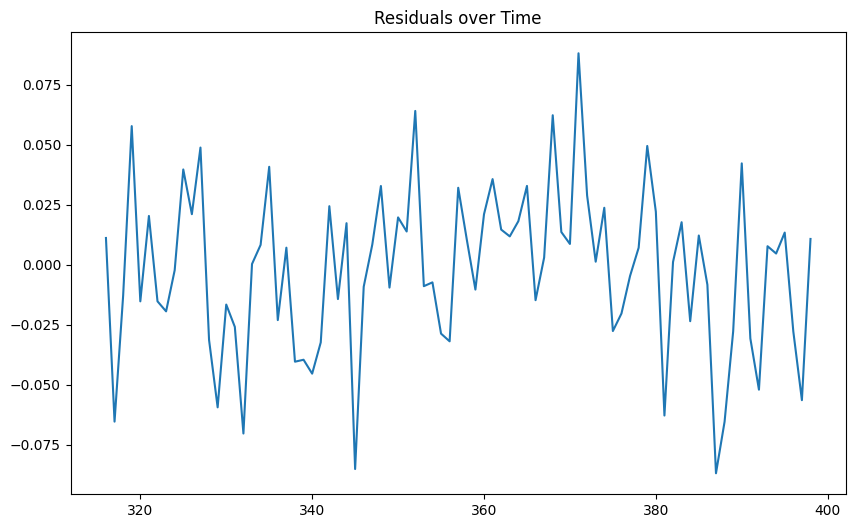

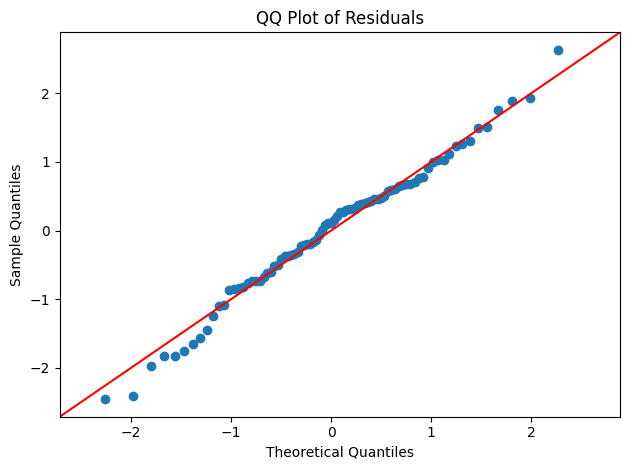

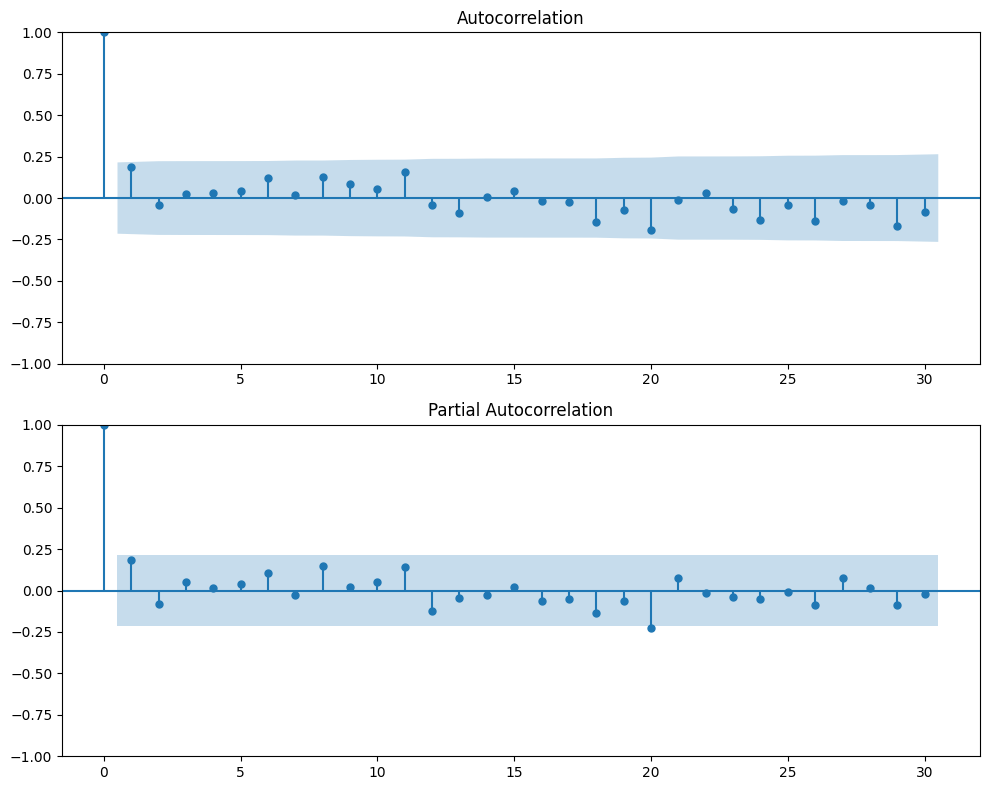

In [89]:
# create a optimal OLS model using the last OLS model

# load optimal_lag_model_data.csv
optimal_data = pd.read_csv("optimal_lag_model_data.csv")
optimal_data['y_lag_1'] = optimal_data['real_prices_diff'].shift(-1)
optimal_data['y_lag_2'] = optimal_data['real_prices_diff'].shift(-2)
optimal_data['y_lag_3'] = optimal_data['real_prices_diff'].shift(-3)
optimal_data = optimal_data.dropna()

from sklearn.model_selection import train_test_split
from statsmodels.api import OLS, add_constant
      
# split into X and y
y_optimal = optimal_data['real_prices_diff']


X_optimal = optimal_data.drop(columns=['real_prices_diff'], axis=1).set_axis(optimal_data.index)
# drop first 3 rows to align with y_optimal
# take 83 obs for the test set (approx 20%)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_optimal, y_optimal, test_size=83, shuffle=False)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Select the specified features
features = [
    'mortgage_rate_diff_lag9',
    'mortgage_rate_diff_lag10', 
    'median_house_income_diff_lag9',
    'median_house_income_diff_lag10',
    'median_house_income_diff_lag11',
    'y_lag_1', 'y_lag_2', 'y_lag_3'
]

X_train_selected = X_train[features]
X_test_selected = X_test[features]

# Fit OLS model
ols_model = OLS(y_train, add_constant(X_train_selected))
ols_results = ols_model.fit()

print(ols_results.summary())

# One-step ahead predictions on test set
y_pred = ols_results.predict(add_constant(X_test_selected))

preds = pd.DataFrame(y_pred, columns=['Predicted'], index=y_test.index)
preds.to_csv("ols_one_step_ahead_predictions.csv")

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("OLS Model - One-Step Ahead Predictions")
print("=" * 50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"\nCoefficients:")
# for feature, coef in zip(features, ols_model.coef_):
#     print(f"  {feature}: {coef:.6f}")
# print(f"  Intercept: {ols_model.intercept_:.6f}")

# Show first few predictions vs actual
comparison = pd.DataFrame({
    'Actual': y_test[:10].values,
    'Predicted': y_pred[:10],
    'Error': y_test[:10].values - y_pred[:10]
})
print(f"\nFirst 10 Predictions:")
print(comparison)       

# do residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))

plt.plot(residuals)
plt.title('Residuals over Time')
plt.show()
sm.qqplot(residuals, line ='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()

# do pacf and acf plots of residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()  

In [ ]:
# # Use Random Forest Feature Importance
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np
# # Train initial model to see which features matter
# rf_initial = RandomForestRegressor(
#     n_estimators=100, 
#     max_depth=5,
#     random_state=42,
#     n_jobs=-1
# )
# rf_initial.fit(X_train, y_train)

# # Get feature importances
# importances = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf_initial.feature_importances_
# }).sort_values('importance', ascending=False)

# print(importances)

# # Keep top N features (e.g., top 10-12)
# top_n = 10
# top_features_idx = np.argsort(rf_initial.feature_importances_)[-top_n:]
# top_features = [X_train.columns[i] for i in top_features_idx]

# print(f"\nTop {top_n} features:")
# print(top_features)

# X_train_top = X_train[:, top_features_idx]
# X_test_top = X_test[:, top_features_idx]

# # Retrain with fewer features
# rf_reduced = RandomForestRegressor(
#     n_estimators=50,
#     max_depth=4,
#     min_samples_split=15,
#     min_samples_leaf=8,
#     random_state=42,
#     n_jobs=-1
# )
# rf_reduced.fit(X_train_top, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

selected_features = ['labor_share_diff_lag4', 'labor_share_diff_lag6', 'labor_share_diff_lag9', 'y_lag_3', 'net_wealth_diff_lag2', 'monthly_supply_homes_diff_lag9', 'labor_share_diff_lag1', 'log_share_net_worth_lag5', 'y_lag_2', 'y_lag_1']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

# drop Unnamed: 0 if exists
if 'Unnamed: 0' in X_train.columns:
    X_train = X_train.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in X_test.columns:
    X_test = X_test.drop(columns=['Unnamed: 0'])
    
print(f"X columns: {X_train.columns.tolist()}")
    

# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=50,        # Number of trees
    max_depth=5,            # Maximum depth of trees
    min_samples_split=15,     # Minimum samples to split a node
    min_samples_leaf=5,      # Minimum samples in leaf node
    max_features=0.5,        # Number of features to consider at each split
    random_state=42,         # For reproducibility
    n_jobs=-1                # Use all CPU cores
)
#'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 50

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Random Forest Model Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Feature importance
if hasattr(X_train, 'columns'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_optimal, y_optimal, test_size=83, shuffle=False)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid focused on reducing overfitting
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 4, 5, 7],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2', 0.5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

# Use best model
best_rf = grid_search.best_estimator_

In [ ]:
# Retrain with OOB scoring enabled
rf_oob = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    oob_score=True,  # Enable OOB scoring
    random_state=42,
    n_jobs=-1
)

rf_oob.fit(X_train, y_train)

oob_score = rf_oob.oob_score_  # R² score on OOB samples
print(f"OOB Score (R²): {oob_score:.4f}")
print(f"Train R²: {r2_score(y_train, rf_oob.predict(X_train)):.4f}")
print(f"Test R²: {test_r2:.4f}")

# OOB score should be between train and test scores

Recommended Action Plan

Start with Lasso - automatic feature selection
Manually reduce lags - keep 1-2 per variable (reduces to ~10 features)
Try Ridge/ElasticNet - often better than RF for linear relationships
If sticking with RF - use max_depth=3, max_features=5, min_samples_leaf=10

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_optimal, y_optimal, test_size=83, shuffle=False)



Number of features: 21
X_train shape: (316, 21)
LASSO REGRESSION WITH AUTOMATIC FEATURE SELECTION

[1] Finding optimal alpha via cross-validation...
✓ Best alpha: 0.001677
✓ Cross-validation MSE: 0.001274

[2] Training Lasso model with optimal alpha...

MODEL PERFORMANCE
Train RMSE: 0.0331
Test RMSE:  0.0325
Overfitting Ratio: 0.98x

Train MAE: 0.0260
Test MAE:  0.0255

Train R²: 0.3542
Test R²:  0.2830

----------------------------------------------------------------------
✓ Model generalizes well (ratio < 1.2x)
----------------------------------------------------------------------

FEATURE SELECTION RESULTS
Coefficient array length: 21
Feature names length: 21

Features selected: 11 / 21
Features dropped: 10

Selected features (with coefficients):
----------------------------------------------------------------------
y_lag_1                                   -0.0237
y_lag_2                                   -0.0068
y_lag_3                                   -0.0035
monthly_supply_home

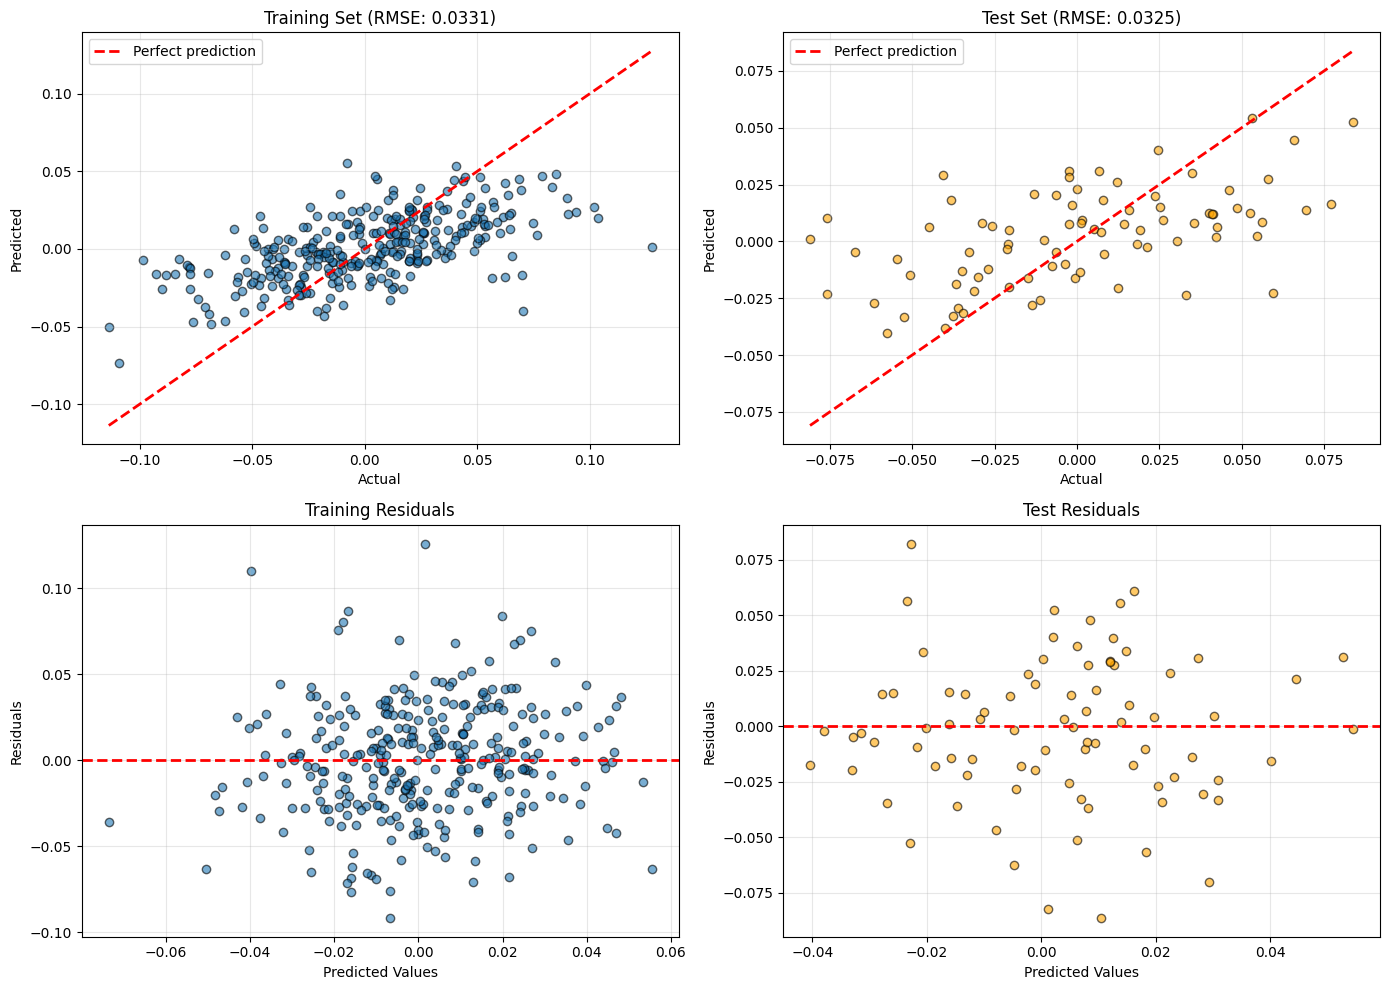

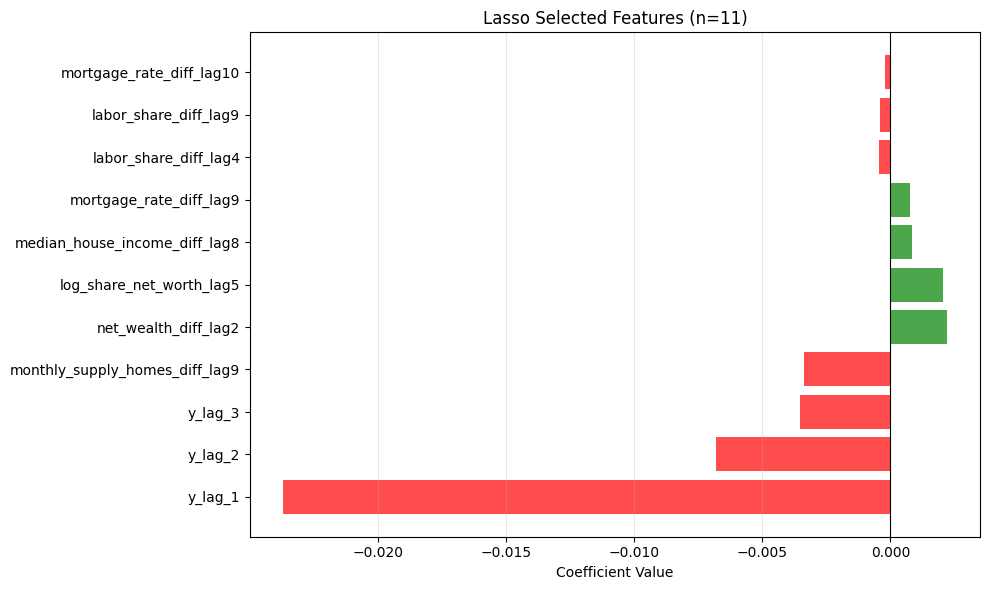

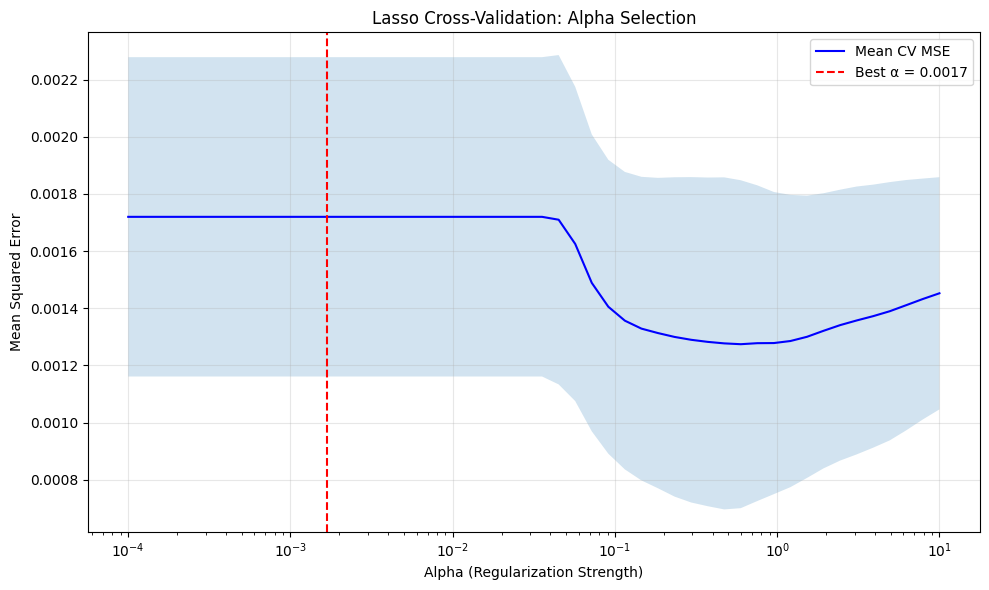


ANALYSIS COMPLETE


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# drop Unnamed: 0 if exists
if 'Unnamed: 0' in X_train.columns:
    X_train = X_train.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in X_test.columns:
    X_test = X_test.drop(columns=['Unnamed: 0'])
    
# # drop y lags 2 and 3 from X_train and X_test if exists
# y_lag_cols = [col for col in X_train.columns if col in ['y_lag_3']]
# X_train = X_train.drop(columns=y_lag_cols)
# X_test = X_test.drop(columns=y_lag_cols)
    
# Get feature column names
# If X_train is a DataFrame, use its columns
if hasattr(X_train, 'columns'):
    X_columns = X_train.columns.tolist()
else:
    # Otherwise use the predefined list
    X_columns = ['net_wealth_diff_lag2', 'net_wealth_diff_lag9', 'mortgage_rate_diff_lag9', 
                 'mortgage_rate_diff_lag10', 'median_house_income_diff_lag2', 
                 'median_house_income_diff_lag3', 'median_house_income_diff_lag8', 
                 'median_house_income_diff_lag9', 'median_house_income_diff_lag10', 
                 'median_house_income_diff_lag11', 'median_house_income_diff_lag12', 
                 'monthly_supply_homes_diff_lag9', 'monthly_supply_homes_diff_lag10', 
                 'labor_share_diff_lag1', 'labor_share_diff_lag4', 'labor_share_diff_lag6', 
                 'labor_share_diff_lag9', 'log_share_net_worth_lag5', 'y_lag_1','y_lag_2', 'y_lag_3'] 
    


print(f"Number of features: {len(X_columns)}")
print(f"X_train shape: {X_train.shape}")

# ============================================================================
# STEP 1: Standardize features (CRITICAL for Lasso)
# ============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("LASSO REGRESSION WITH AUTOMATIC FEATURE SELECTION")
print("=" * 70)

# ============================================================================
# STEP 2: Cross-validation to find best alpha (regularization strength)
# ============================================================================
print("\n[1] Finding optimal alpha via cross-validation...")

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Range of alpha values to try (higher = more regularization)
alphas = np.logspace(-4, 1, 50)  # From 0.0001 to 10

lasso_cv = LassoCV(
    alphas=alphas,
    cv=tscv,
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)

lasso_cv.fit(X_train_scaled, y_train)

print(f"✓ Best alpha: {lasso_cv.alpha_:.6f}")
print(f"✓ Cross-validation MSE: {lasso_cv.mse_path_.mean(axis=1).min():.6f}")

# ============================================================================
# STEP 3: Train final model with best alpha
# ============================================================================
print("\n[2] Training Lasso model with optimal alpha...")

lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42)
lasso.fit(X_train_scaled, y_train)

# ============================================================================
# STEP 4: Make predictions
# ============================================================================
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# ============================================================================
# STEP 5: Evaluate performance
# ============================================================================
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Overfitting Ratio: {test_rmse/train_rmse:.2f}x")
print(f"\nTrain MAE: {train_mae:.4f}")
print(f"Test MAE:  {test_mae:.4f}")
print(f"\nTrain R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")

# Overfitting assessment
print("\n" + "-" * 70)
if test_rmse / train_rmse < 1.2:
    print("✓ Model generalizes well (ratio < 1.2x)")
elif test_rmse / train_rmse < 1.5:
    print("⚠ Mild overfitting (ratio 1.2-1.5x)")
else:
    print("✗ Significant overfitting (ratio > 1.5x)")
print("-" * 70)

# ============================================================================
# STEP 6: Feature selection - which features were kept?
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE SELECTION RESULTS")
print("=" * 70)

# Get non-zero coefficients
print(f"Coefficient array length: {len(lasso.coef_)}")
print(f"Feature names length: {len(X_columns)}")

# Ensure lengths match
if len(lasso.coef_) != len(X_columns):
    print(f"Warning: Mismatch between coefficients ({len(lasso.coef_)}) and feature names ({len(X_columns)})")
    # Use generic names if mismatch
    X_columns = [f"Feature_{i}" for i in range(len(lasso.coef_))]

coefficients = pd.DataFrame({
    'Feature': X_columns,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

n_selected = np.sum(lasso.coef_ != 0)
n_dropped = len(X_columns) - n_selected

print(f"\nFeatures selected: {n_selected} / {len(X_columns)}")
print(f"Features dropped: {n_dropped}")
print(f"\nSelected features (with coefficients):")
print("-" * 70)

for idx, row in coefficients[coefficients['Coefficient'] != 0].iterrows():
    print(f"{row['Feature']:40s} {row['Coefficient']:8.4f}")

if n_dropped > 0:
    print(f"\nDropped features ({n_dropped}):")
    print("-" * 70)
    for idx, row in coefficients[coefficients['Coefficient'] == 0].iterrows():
        print(f"{row['Feature']}")

# ============================================================================
# STEP 7: Visualizations
# ============================================================================

# Plot 1: Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Train set
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'Training Set (RMSE: {train_rmse:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test set
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='orange', edgecolors='k')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title(f'Test Set (RMSE: {test_rmse:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals - Train
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, edgecolors='k')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Training Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Residuals - Test
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='orange', edgecolors='k')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Test Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Feature importance (non-zero coefficients)
if n_selected > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    selected_features = coefficients[coefficients['Coefficient'] != 0].copy()
    colors = ['green' if x > 0 else 'red' for x in selected_features['Coefficient']]
    
    ax.barh(range(len(selected_features)), selected_features['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(selected_features)))
    ax.set_yticklabels(selected_features['Feature'])
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Lasso Selected Features (n={n_selected})')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

# Plot 3: Cross-validation path
fig, ax = plt.subplots(figsize=(10, 6))
mean_mse = lasso_cv.mse_path_.mean(axis=1)
std_mse = lasso_cv.mse_path_.std(axis=1)

ax.semilogx(alphas, mean_mse, 'b-', label='Mean CV MSE')
ax.fill_between(alphas, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2)
ax.axvline(lasso_cv.alpha_, color='r', linestyle='--', label=f'Best α = {lasso_cv.alpha_:.4f}')
ax.set_xlabel('Alpha (Regularization Strength)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Lasso Cross-Validation: Alpha Selection')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

LASSO vs AR(3) BENCHMARK COMPARISON
Training observations: 316
Test observations: 83

[1] Training Lasso Model with all features...
✓ Best alpha: 0.001677
✓ Lasso Train RMSE: 0.0331
✓ Lasso Test RMSE:  0.0325

[2] Training AR(3) Model with 1-step ahead forecast...
✓ AR(3) coefficients: [-0.66860589 -0.30791953 -0.18675597  0.00255349]
✓ AR(3) Train RMSE: 0.0336
✓ AR(3) Test RMSE:  0.0324

MODEL COMPARISON
             Model    Features  Train RMSE  Test RMSE  Train R²  Test R²  Overfit Ratio
Lasso (with macro) 11 selected    0.033109   0.032470  0.354221 0.283040       0.980705
   AR(3) Benchmark 3 lags only    0.033628   0.032419  0.332845 0.285295       0.964039

IMPROVEMENT OVER AR(3) BENCHMARK:
  Absolute: -0.0001 reduction in RMSE
  Relative: -0.16% better
✗ NO improvement - AR(3) performs better

VARIANCE DECOMPOSITION
Total Lasso prediction variance:  0.000421 (100.0%)
AR(3) component variance:         0.000503 (119.6%)
Macro adjustment variance:        0.000800 (190.0%)

✓ Macr

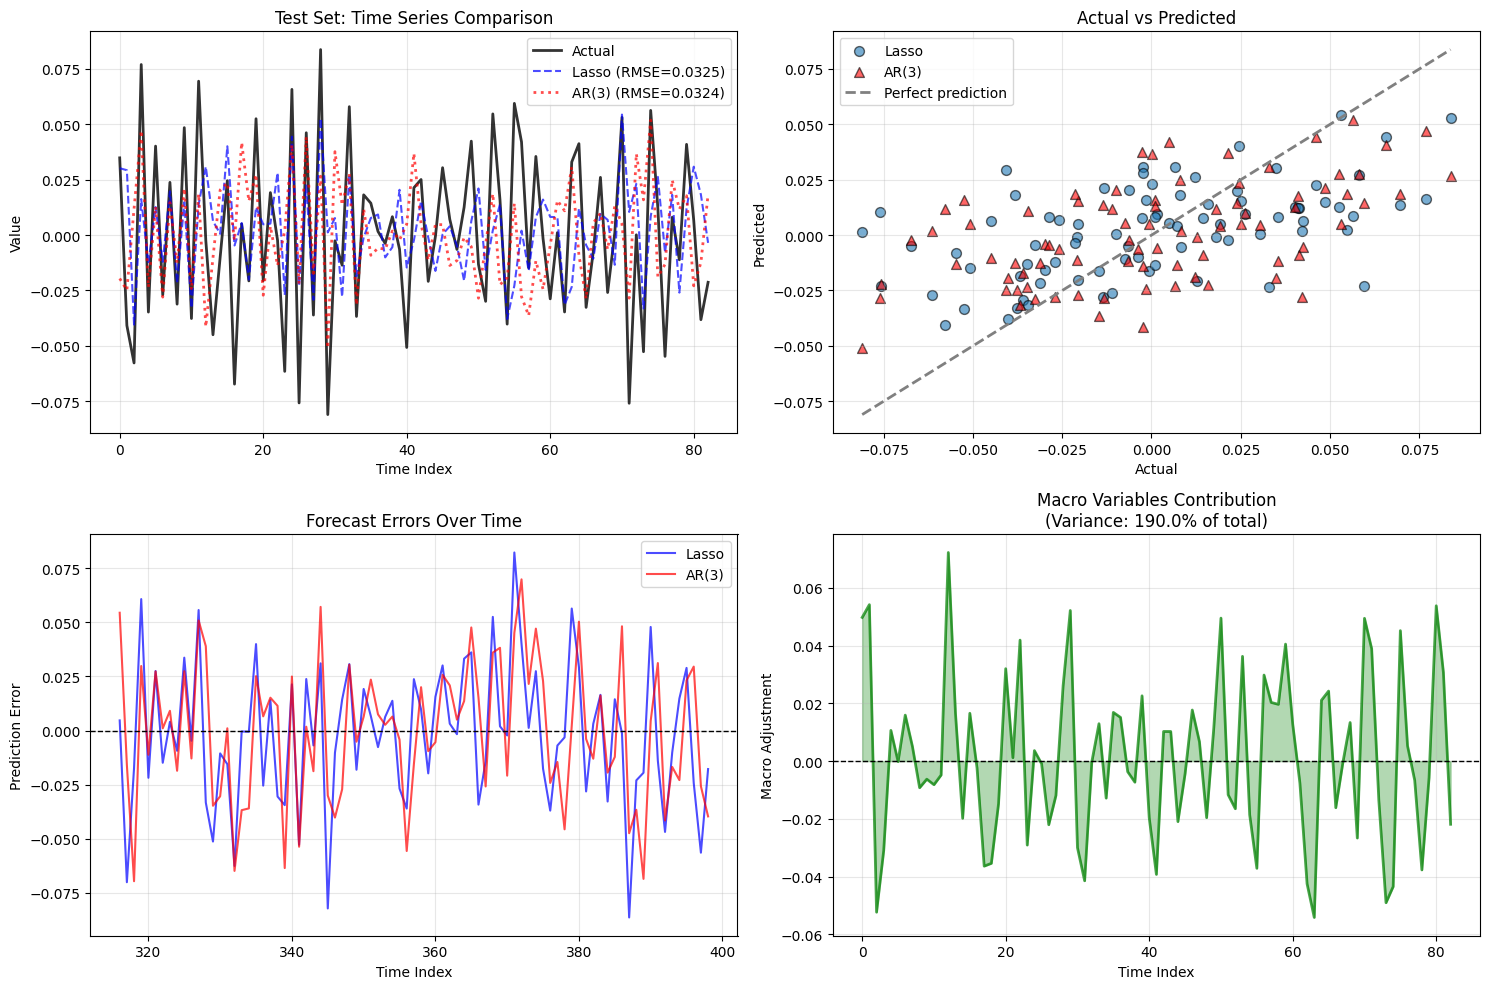

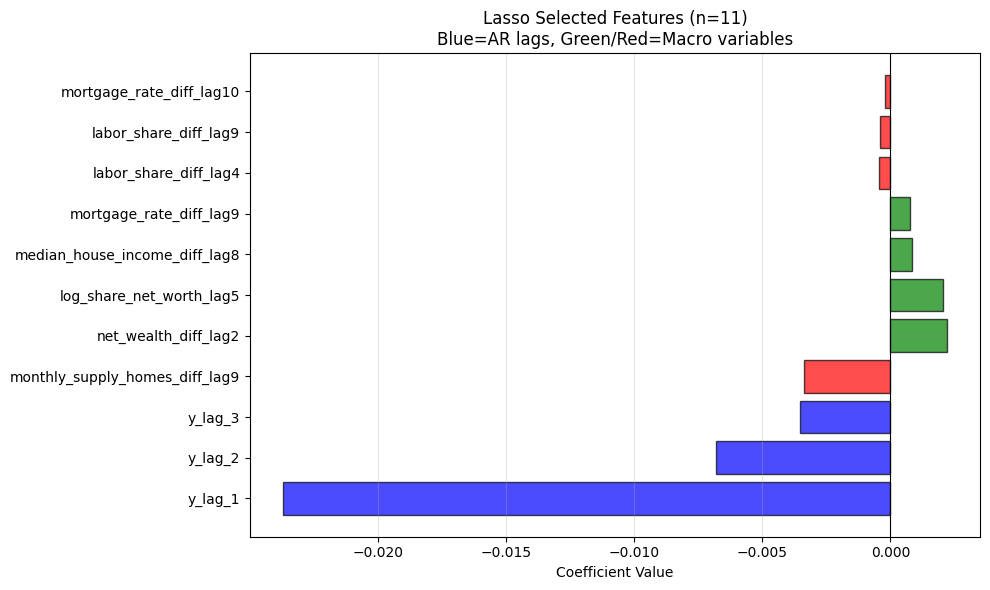


ANALYSIS COMPLETE


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# ============================================================================
# AR(3) Functions (from provided code)
# ============================================================================

def create_ar3_features(y, lag=3):
    """Create lagged features for AR(3) model"""
    n = len(y)
    X = np.zeros((n - lag, lag))
    y_target = np.zeros(n - lag)
    
    for i in range(lag, n):
        X[i - lag] = [y[i-1], y[i-2], y[i-3]]
        y_target[i - lag] = y[i]
    
    return X, y_target


def fit_ar3(y_train):
    """Fit AR(3) model using OLS"""
    X, y_target = create_ar3_features(y_train, lag=3)
    
    # Add intercept
    X_with_intercept = np.column_stack([X, np.ones(len(X))])
    
    # OLS estimation: beta = (X'X)^(-1) X'y
    coeffs = np.linalg.lstsq(X_with_intercept, y_target, rcond=None)[0]
    
    return coeffs  # [phi1, phi2, phi3, intercept]


def predict_ar3(y_history, coeffs, steps=1):
    """Predict next value(s) using AR(3) model"""
    y_history = np.array(y_history).flatten()
    predictions = []
    
    # Make a copy to avoid modifying original
    history = list(y_history[-3:])  # Keep last 3 values
    
    for _ in range(steps):
        # AR(3): y_t = phi1*y_{t-1} + phi2*y_{t-2} + phi3*y_{t-3} + c
        pred = (coeffs[0] * history[-1] + 
                coeffs[1] * history[-2] + 
                coeffs[2] * history[-3] + 
                coeffs[3])
        
        predictions.append(pred)
        history.append(pred)
        
    return np.array(predictions)


def one_step_forecast(y, train_size):
    """
    One-step ahead: Train once, predict all test observations sequentially
    Uses true observed values for each prediction (not forecasted values)
    """
    # Split data
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Train once
    coeffs = fit_ar3(y_train)
    
    # Get fitted values for training set
    X_train, y_train_target = create_ar3_features(y_train, lag=3)
    X_train_with_intercept = np.column_stack([X_train, np.ones(len(X_train))])
    y_train_fitted = X_train_with_intercept @ coeffs
    
    # Predict each test observation using actual historical values
    predictions = []
    for i in range(len(y_test)):
        # Use actual values from history (not predictions)
        if i == 0:
            history = y_train[-3:]
        elif i == 1:
            history = np.concatenate([y_train[-2:], [y[train_size]]])
        elif i == 2:
            history = np.concatenate([y_train[-1:], y[train_size:train_size+2]])
        else:
            history = y[train_size+i-3:train_size+i]
        
        pred = predict_ar3(history, coeffs, steps=1)[0]
        predictions.append(pred)
    
    return np.array(predictions), y_test, y_train_fitted, y_train_target, coeffs


# ============================================================================
# Main Analysis
# ============================================================================

# Get feature column names
if hasattr(X_train, 'columns'):
    X_columns = X_train.columns.tolist()
else:
    X_columns = ['net_wealth_diff_lag2', 'net_wealth_diff_lag9', 'mortgage_rate_diff_lag9', 
                 'mortgage_rate_diff_lag10', 'median_house_income_diff_lag2', 
                 'median_house_income_diff_lag3', 'median_house_income_diff_lag8', 
                 'median_house_income_diff_lag9', 'median_house_income_diff_lag10', 
                 'median_house_income_diff_lag11', 'median_house_income_diff_lag12', 
                 'monthly_supply_homes_diff_lag9', 'monthly_supply_homes_diff_lag10', 
                 'labor_share_diff_lag1', 'labor_share_diff_lag4', 'labor_share_diff_lag6', 
                 'labor_share_diff_lag9', 'log_share_net_worth_lag5', 'y_lag_1', 'y_lag_2', 'y_lag_3']

print("=" * 80)
print("LASSO vs AR(3) BENCHMARK COMPARISON")
print("=" * 80)
print(f"Training observations: {len(y_train)}")
print(f"Test observations: {len(y_test)}")

# ============================================================================
# PART 1: Train Lasso Model (Your Full Model)
# ============================================================================
print("\n[1] Training Lasso Model with all features...")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross-validation to find best alpha
tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-4, 1, 50)

lasso_cv = LassoCV(alphas=alphas, cv=tscv, max_iter=10000, random_state=42, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

print(f"✓ Best alpha: {lasso_cv.alpha_:.6f}")

# Train final model
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"✓ Lasso Train RMSE: {train_rmse_lasso:.4f}")
print(f"✓ Lasso Test RMSE:  {test_rmse_lasso:.4f}")

# ============================================================================
# PART 2: Train AR(3) Model - 1-Step Ahead Forecast
# ============================================================================
print("\n[2] Training AR(3) Model with 1-step ahead forecast...")

# Combine train and test for AR(3)
y_full = np.concatenate([y_train, y_test])
train_size = len(y_train)

# Run 1-step ahead forecast
y_test_pred_ar3, y_test_ar3, y_train_pred_ar3, y_train_target_ar3, ar3_coeffs = one_step_forecast(
    y_full, train_size
)

print(f"✓ AR(3) coefficients: {ar3_coeffs}")

# Evaluate AR(3)
# Note: y_test_ar3 is just y_test (returned from one_step_forecast)
train_rmse_ar3 = np.sqrt(mean_squared_error(y_train_target_ar3, y_train_pred_ar3))
test_rmse_ar3 = np.sqrt(mean_squared_error(y_test, y_test_pred_ar3))
train_r2_ar3 = r2_score(y_train_target_ar3, y_train_pred_ar3)
test_r2_ar3 = r2_score(y_test, y_test_pred_ar3)

print(f"✓ AR(3) Train RMSE: {train_rmse_ar3:.4f}")
print(f"✓ AR(3) Test RMSE:  {test_rmse_ar3:.4f}")

# ============================================================================
# PART 3: Model Comparison
# ============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

results_df = pd.DataFrame({
    'Model': ['Lasso (with macro)', 'AR(3) Benchmark'],
    'Features': [f"{np.sum(lasso.coef_ != 0)} selected", '3 lags only'],
    'Train RMSE': [train_rmse_lasso, train_rmse_ar3],
    'Test RMSE': [test_rmse_lasso, test_rmse_ar3],
    'Train R²': [train_r2_lasso, train_r2_ar3],
    'Test R²': [test_r2_lasso, test_r2_ar3],
    'Overfit Ratio': [test_rmse_lasso/train_rmse_lasso, test_rmse_ar3/train_rmse_ar3]
})

print(results_df.to_string(index=False))

# Calculate improvement
improvement = (test_rmse_ar3 - test_rmse_lasso) / test_rmse_ar3 * 100
abs_improvement = test_rmse_ar3 - test_rmse_lasso

print(f"\n{'='*80}")
print(f"IMPROVEMENT OVER AR(3) BENCHMARK:")
print(f"  Absolute: {abs_improvement:.4f} reduction in RMSE")
print(f"  Relative: {improvement:.2f}% better")
print(f"{'='*80}")

if improvement > 10:
    print("✓✓ SUBSTANTIAL improvement - macro variables add significant value!")
elif improvement > 5:
    print("✓ GOOD improvement - macro variables add meaningful value")
elif improvement > 0:
    print("⚠ MODEST improvement - macro variables add some value")
else:
    print("✗ NO improvement - AR(3) performs better")

# ============================================================================
# PART 4: Variance Decomposition
# ============================================================================
print("\n" + "=" * 80)
print("VARIANCE DECOMPOSITION")
print("=" * 80)

# How much variance is explained by each component?
total_var = np.var(y_test_pred_lasso)
ar3_var = np.var(y_test_pred_ar3)

# Macro contribution = difference between predictions
macro_contribution = y_test_pred_lasso - y_test_pred_ar3
macro_var = np.var(macro_contribution)

print(f"Total Lasso prediction variance:  {total_var:.6f} (100.0%)")
print(f"AR(3) component variance:         {ar3_var:.6f} ({ar3_var/total_var*100:.1f}%)")
print(f"Macro adjustment variance:        {macro_var:.6f} ({macro_var/total_var*100:.1f}%)")

if macro_var / total_var > 0.15:
    print("\n✓ Macro variables contribute substantially to predictions (>15%)")
elif macro_var / total_var > 0.05:
    print("\n⚠ Macro variables contribute modestly to predictions (5-15%)")
else:
    print("\n✗ Macro variables contribute minimally to predictions (<5%)")

# ============================================================================
# PART 5: Statistical Significance Test
# ============================================================================
print("\n" + "=" * 80)
print("F-TEST: Are macro variables jointly significant?")
print("=" * 80)

# Residuals from each model
residuals_ar3 = y_test - y_test_pred_ar3
residuals_lasso = y_test - y_test_pred_lasso

# RSS (Residual Sum of Squares)
rss_ar3 = np.sum(residuals_ar3**2)
rss_lasso = np.sum(residuals_lasso**2)

# Degrees of freedom
n = len(y_test)
k_ar3 = 4  # 3 AR parameters + intercept
k_lasso = np.sum(lasso.coef_ != 0)  # Number of selected features

print(f"AR(3) parameters: {k_ar3}")
print(f"Lasso parameters: {k_lasso}")

# F-test
if k_lasso > k_ar3 and rss_lasso < rss_ar3:
    f_stat = ((rss_ar3 - rss_lasso) / (k_lasso - k_ar3)) / (rss_lasso / (n - k_lasso - 1))
    p_value = 1 - stats.f.cdf(f_stat, k_lasso - k_ar3, n - k_lasso - 1)
    
    print(f"\nF-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.01:
        print("✓✓ Macro variables are HIGHLY significant (p < 0.01)")
    elif p_value < 0.05:
        print("✓ Macro variables are significant at 5% level")
    elif p_value < 0.10:
        print("⚠ Macro variables are marginally significant (p < 0.10)")
    else:
        print("✗ Macro variables are NOT statistically significant")
else:
    print("\nCannot perform F-test (Lasso RSS not lower than AR(3) or fewer parameters)")

# ============================================================================
# PART 6: Selected Features
# ============================================================================
print("\n" + "=" * 80)
print("LASSO SELECTED FEATURES")
print("=" * 80)

coefficients = pd.DataFrame({
    'Feature': X_columns,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

n_selected = np.sum(lasso.coef_ != 0)
print(f"\nFeatures selected: {n_selected} / {len(X_columns)}")
print(f"\nSelected features (with coefficients):")
print("-" * 80)

for idx, row in coefficients[coefficients['Coefficient'] != 0].iterrows():
    feature_type = "AR lag" if "y_lag" in row['Feature'] else "Macro"
    print(f"{row['Feature']:40s} {row['Coefficient']:8.4f}  [{feature_type}]")

# Count AR vs Macro features
ar_features = sum(1 for f in coefficients[coefficients['Coefficient'] != 0]['Feature'] if 'y_lag' in f)
macro_features = n_selected - ar_features
print(f"\nBreakdown: {ar_features} AR lags + {macro_features} macro variables")

# ============================================================================
# PART 7: Visualizations
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time Series Comparison
axes[0, 0].plot(range(len(y_test)), y_test, 'k-', label='Actual', linewidth=2, alpha=0.8)
axes[0, 0].plot(range(len(y_test_pred_lasso)), y_test_pred_lasso, 'b--', label=f'Lasso (RMSE={test_rmse_lasso:.4f})', 
                linewidth=1.5, alpha=0.7)
axes[0, 0].plot(range(len(y_test_pred_ar3)), y_test_pred_ar3, 'r:', label=f'AR(3) (RMSE={test_rmse_ar3:.4f})', 
                linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Test Set: Time Series Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
axes[0, 1].scatter(y_test, y_test_pred_lasso, alpha=0.6, edgecolors='k', 
                   label='Lasso', s=50)
axes[0, 1].scatter(y_test, y_test_pred_ar3, alpha=0.6, color='red', 
                   edgecolors='k', label='AR(3)', s=50, marker='^')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'gray', linestyle='--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title('Actual vs Predicted')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction Errors Comparison
errors_lasso = y_test - y_test_pred_lasso
errors_ar3 = y_test - y_test_pred_ar3

axes[1, 0].plot(errors_lasso, 'b-', label='Lasso', alpha=0.7, linewidth=1.5)
axes[1, 0].plot(errors_ar3, 'r-', label='AR(3)', alpha=0.7, linewidth=1.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Forecast Errors Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Macro Contribution
axes[1, 1].plot(macro_contribution, 'g-', linewidth=2, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].fill_between(range(len(macro_contribution)), macro_contribution, 0, 
                        alpha=0.3, color='green')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Macro Adjustment')
axes[1, 1].set_title(f'Macro Variables Contribution\n(Variance: {macro_var/total_var*100:.1f}% of total)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot feature importance
if n_selected > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    selected_features = coefficients[coefficients['Coefficient'] != 0].copy()
    colors = ['blue' if 'y_lag' in f else 'green' if c > 0 else 'red' 
              for f, c in zip(selected_features['Feature'], selected_features['Coefficient'])]
    
    ax.barh(range(len(selected_features)), selected_features['Coefficient'], 
            color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(selected_features)))
    ax.set_yticklabels(selected_features['Feature'])
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Lasso Selected Features (n={n_selected})\nBlue=AR lags, Green/Red=Macro variables')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

TRUE 1-STEP AHEAD COMPARISON: LASSO vs AR(3)
Total observations: 399
Training size: 316
Test size: 83
Features: 22

[1] Running TRUE 1-step ahead Lasso (expanding window)...
Performing expanding window forecast for 83 test observations...
  Finding optimal alpha on initial training set...
  Optimal alpha: 0.001610
  Progress: 1/83 forecasts completed
  Progress: 20/83 forecasts completed
  Progress: 40/83 forecasts completed
  Progress: 60/83 forecasts completed
  Progress: 80/83 forecasts completed

✓ Lasso Train RMSE: 0.0330
✓ Lasso Test RMSE:  0.0322

[2] Running AR(3) 1-step ahead forecast...

✓ AR(3) Train RMSE: 0.0336
✓ AR(3) Test RMSE:  0.0324

MODEL COMPARISON (TRUE 1-STEP AHEAD)
            Model            Method  Train RMSE  Test RMSE  Train R²  Test R²  Overfit Ratio
Lasso (Expanding) Retrain each step    0.033027   0.032234  0.357415 0.293433       0.975987
  AR(3) Benchmark Retrain each step    0.033628   0.032419  0.332845 0.285295       0.964039

IMPROVEMENT OVER AR(3):

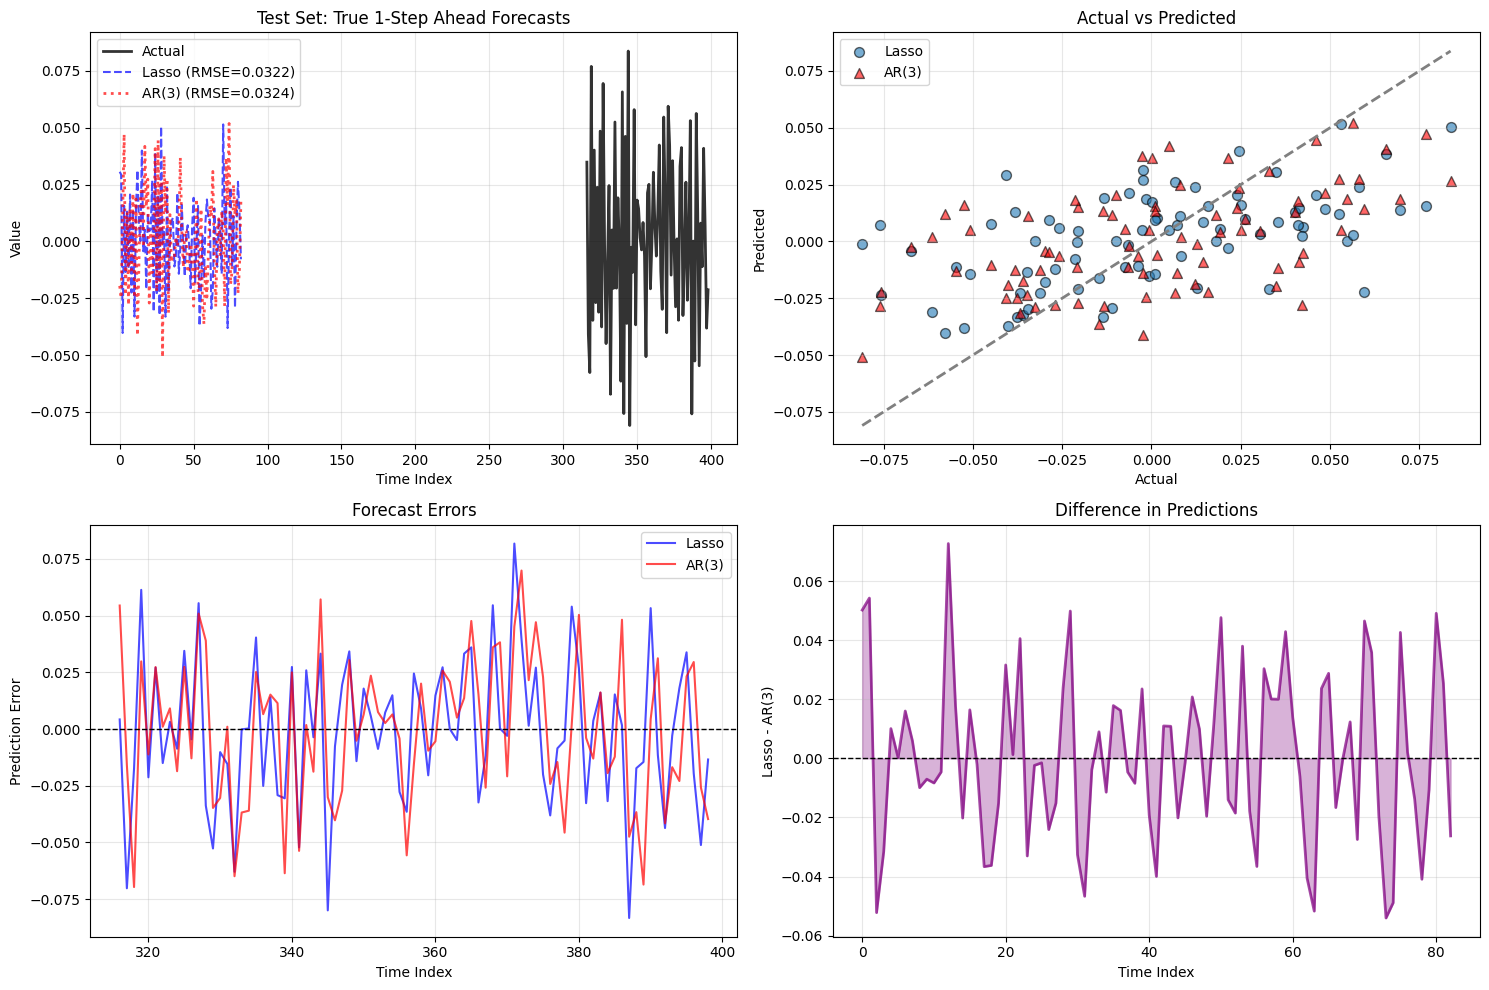


ANALYSIS COMPLETE

Note: This is TRUE 1-step ahead forecasting where the model is
retrained at each step using all available data up to that point.


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# ============================================================================
# AR(3) Functions
# ============================================================================

def create_ar3_features(y, lag=3):
    """Create lagged features for AR(3) model"""
    n = len(y)
    X = np.zeros((n - lag, lag))
    y_target = np.zeros(n - lag)
    
    for i in range(lag, n):
        X[i - lag] = [y[i-1], y[i-2], y[i-3]]
        y_target[i - lag] = y[i]
    
    return X, y_target


def fit_ar3(y_train):
    """Fit AR(3) model using OLS"""
    X, y_target = create_ar3_features(y_train, lag=3)
    X_with_intercept = np.column_stack([X, np.ones(len(X))])
    coeffs = np.linalg.lstsq(X_with_intercept, y_target, rcond=None)[0]
    return coeffs


def predict_ar3(y_history, coeffs, steps=1):
    """Predict next value(s) using AR(3) model"""
    y_history = np.array(y_history).flatten()
    predictions = []
    history = list(y_history[-3:])
    
    for _ in range(steps):
        pred = (coeffs[0] * history[-1] + 
                coeffs[1] * history[-2] + 
                coeffs[2] * history[-3] + 
                coeffs[3])
        predictions.append(pred)
        history.append(pred)
        
    return np.array(predictions)


def ar3_one_step_forecast(y, train_size):
    """One-step ahead forecast using AR(3)"""
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    coeffs = fit_ar3(y_train)
    
    X_train, y_train_target = create_ar3_features(y_train, lag=3)
    X_train_with_intercept = np.column_stack([X_train, np.ones(len(X_train))])
    y_train_fitted = X_train_with_intercept @ coeffs
    
    predictions = []
    for i in range(len(y_test)):
        if i == 0:
            history = y_train[-3:]
        elif i == 1:
            history = np.concatenate([y_train[-2:], [y[train_size]]])
        elif i == 2:
            history = np.concatenate([y_train[-1:], y[train_size:train_size+2]])
        else:
            history = y[train_size+i-3:train_size+i]
        
        pred = predict_ar3(history, coeffs, steps=1)[0]
        predictions.append(pred)
    
    return np.array(predictions), y_test, y_train_fitted, y_train_target, coeffs


# ============================================================================
# Lasso True 1-Step Ahead Forecasting
# ============================================================================

def lasso_expanding_window_forecast(X, y, train_size, alpha=None):
    """
    True 1-step ahead forecasting with expanding window
    
    For each test point t:
    - Train on all data from 0 to t-1
    - Predict t
    - Add t to training set
    - Repeat
    
    Args:
        X: Full feature matrix (train + test combined)
        y: Full target vector (train + test combined)
        train_size: Number of initial training observations
        alpha: Lasso regularization parameter (if None, uses CV on initial training set)
    
    Returns:
        train_predictions, test_predictions, test_actuals
    """
    n_total = len(y)
    n_test = n_total - train_size
    
    # Initialize
    test_predictions = []
    test_actuals = []
    alphas_used = []
    
    print(f"Performing expanding window forecast for {n_test} test observations...")
    
    # Initial training
    X_initial = X[:train_size]
    y_initial = y[:train_size]
    
    # Determine alpha if not provided
    if alpha is None:
        from sklearn.linear_model import LassoCV
        from sklearn.model_selection import TimeSeriesSplit
        
        print("  Finding optimal alpha on initial training set...")
        tscv = TimeSeriesSplit(n_splits=5)
        alphas_cv = np.logspace(-4, 1, 30)
        
        scaler_cv = StandardScaler()
        X_initial_scaled = scaler_cv.fit_transform(X_initial)
        
        lasso_cv = LassoCV(alphas=alphas_cv, cv=tscv, max_iter=10000, random_state=42, n_jobs=-1)
        lasso_cv.fit(X_initial_scaled, y_initial)
        alpha = lasso_cv.alpha_
        print(f"  Optimal alpha: {alpha:.6f}")
    
    # Get initial train predictions
    scaler_init = StandardScaler()
    X_initial_scaled = scaler_init.fit_transform(X_initial)
    lasso_init = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_init.fit(X_initial_scaled, y_initial)
    train_predictions = lasso_init.predict(X_initial_scaled)
    
    # Expanding window: retrain for each test observation
    for i in range(n_test):
        if (i + 1) % 20 == 0 or i == 0:
            print(f"  Progress: {i+1}/{n_test} forecasts completed")
        
        # Training data: from start to current point
        train_end = train_size + i
        X_train_current = X[:train_end]
        y_train_current = y[:train_end]
        
        # Test data: next observation
        X_test_current = X[train_end:train_end+1]
        y_test_current = y[train_end]
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_current)
        X_test_scaled = scaler.transform(X_test_current)
        
        # Train Lasso
        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        lasso.fit(X_train_scaled, y_train_current)
        
        # Predict
        pred = lasso.predict(X_test_scaled)[0]
        
        test_predictions.append(pred)
        test_actuals.append(y_test_current)
        alphas_used.append(alpha)
    
    return train_predictions, np.array(test_predictions), np.array(test_actuals)


# ============================================================================
# Main Comparison
# ============================================================================

print("=" * 80)
print("TRUE 1-STEP AHEAD COMPARISON: LASSO vs AR(3)")
print("=" * 80)

# Get feature columns
if hasattr(X_train, 'columns'):
    X_columns = X_train.columns.tolist()
else:
    X_columns = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Combine train and test
if hasattr(X_train, 'values'):
    X_full = np.vstack([X_train.values, X_test.values])
else:
    X_full = np.vstack([X_train, X_test])

y_full = np.concatenate([y_train, y_test])
train_size = len(y_train)

print(f"Total observations: {len(y_full)}")
print(f"Training size: {train_size}")
print(f"Test size: {len(y_test)}")
print(f"Features: {len(X_columns)}")

# ============================================================================
# PART 1: True 1-Step Ahead Lasso
# ============================================================================
print("\n[1] Running TRUE 1-step ahead Lasso (expanding window)...")

y_train_pred_lasso, y_test_pred_lasso, y_test_actual_lasso = lasso_expanding_window_forecast(
    X_full, y_full, train_size, alpha=None  # Will use CV to find alpha
)

# Evaluate
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"\n✓ Lasso Train RMSE: {train_rmse_lasso:.4f}")
print(f"✓ Lasso Test RMSE:  {test_rmse_lasso:.4f}")

# ============================================================================
# PART 2: AR(3) 1-Step Ahead
# ============================================================================
print("\n[2] Running AR(3) 1-step ahead forecast...")

y_test_pred_ar3, y_test_ar3, y_train_pred_ar3, y_train_target_ar3, ar3_coeffs = ar3_one_step_forecast(
    y_full, train_size
)

train_rmse_ar3 = np.sqrt(mean_squared_error(y_train_target_ar3, y_train_pred_ar3))
test_rmse_ar3 = np.sqrt(mean_squared_error(y_test, y_test_pred_ar3))
train_r2_ar3 = r2_score(y_train_target_ar3, y_train_pred_ar3)
test_r2_ar3 = r2_score(y_test, y_test_pred_ar3)

print(f"\n✓ AR(3) Train RMSE: {train_rmse_ar3:.4f}")
print(f"✓ AR(3) Test RMSE:  {test_rmse_ar3:.4f}")

# ============================================================================
# PART 3: Comparison
# ============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON (TRUE 1-STEP AHEAD)")
print("=" * 80)

results_df = pd.DataFrame({
    'Model': ['Lasso (Expanding)', 'AR(3) Benchmark'],
    'Method': ['Retrain each step', 'Retrain each step'],
    'Train RMSE': [train_rmse_lasso, train_rmse_ar3],
    'Test RMSE': [test_rmse_lasso, test_rmse_ar3],
    'Train R²': [train_r2_lasso, train_r2_ar3],
    'Test R²': [test_r2_lasso, test_r2_ar3],
    'Overfit Ratio': [test_rmse_lasso/train_rmse_lasso, test_rmse_ar3/train_rmse_ar3]
})

print(results_df.to_string(index=False))

improvement = (test_rmse_ar3 - test_rmse_lasso) / test_rmse_ar3 * 100
abs_improvement = test_rmse_ar3 - test_rmse_lasso

print(f"\n{'='*80}")
print(f"IMPROVEMENT OVER AR(3):")
print(f"  Absolute: {abs_improvement:.4f}")
print(f"  Relative: {improvement:.2f}%")
print(f"{'='*80}")

if improvement > 5:
    print("✓ Lasso adds meaningful value with true 1-step ahead forecasting")
elif improvement > 0:
    print("⚠ Lasso slightly better, but marginal improvement")
else:
    print("✗ AR(3) performs better even with true 1-step ahead comparison")

# ============================================================================
# PART 4: Visualizations
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time Series
axes[0, 0].plot(y_test, 'k-', label='Actual', linewidth=2, alpha=0.8)
axes[0, 0].plot(y_test_pred_lasso, 'b--', label=f'Lasso (RMSE={test_rmse_lasso:.4f})', 
                linewidth=1.5, alpha=0.7)
axes[0, 0].plot(y_test_pred_ar3, 'r:', label=f'AR(3) (RMSE={test_rmse_ar3:.4f})', 
                linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Test Set: True 1-Step Ahead Forecasts')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
axes[0, 1].scatter(y_test, y_test_pred_lasso, alpha=0.6, edgecolors='k', label='Lasso', s=50)
axes[0, 1].scatter(y_test, y_test_pred_ar3, alpha=0.6, color='red', 
                   edgecolors='k', label='AR(3)', s=50, marker='^')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'gray', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].set_title('Actual vs Predicted')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Errors
errors_lasso = y_test - y_test_pred_lasso
errors_ar3 = y_test - y_test_pred_ar3

axes[1, 0].plot(errors_lasso, 'b-', label='Lasso', alpha=0.7, linewidth=1.5)
axes[1, 0].plot(errors_ar3, 'r-', label='AR(3)', alpha=0.7, linewidth=1.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Forecast Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Difference
diff = y_test_pred_lasso - y_test_pred_ar3
axes[1, 1].plot(diff, 'purple', linewidth=2, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].fill_between(range(len(diff)), diff, 0, alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Lasso - AR(3)')
axes[1, 1].set_title('Difference in Predictions')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nNote: This is TRUE 1-step ahead forecasting where the model is")
print("retrained at each step using all available data up to that point.")